##### Copyright 2018 The TensorFlow Authors.



# Image captioning with visual attention


Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [4]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# 맷플롯립
import matplotlib.pyplot as plt

# 사이킷런(데이터 분할, 셔플용)
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pprint
import cv2
print(tf.__version__)

2.1.0


In [ ]:
# # Download caption annotation files
# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
#                                           extract = True)
#   annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
#   os.remove(annotation_zip)

# # Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

## 1. 데이터 전처리
* 데이터 수 제한하기(3000개만 추출)
* 속도를 빠르게 하기 위해서 30000개만으로 학습한다. 더 많은 그림을 넣으면 모델 품질이 개선된다.

In [5]:
# json 파일 읽기
annotation_file = './annotations/captions_train2014.json'
PATH = './train2014/'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
# json 파일 뽑아보기
print('---------------------annotations----------------------')
pprint.pprint(annotations['annotations'][:3])

# 캡션, 이미지 벡터 저장
all_captions = []
all_img_path = []

for annot in annotations['annotations']:
    # <start>와 <end>를 처음과 끝에 넣어 구분해준다.
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    # 이미지 패스 저장
    all_img_path.append(full_coco_image_path)
    # 이미지 캡션 저장
    all_captions.append(caption)

# 캡션과 이미지 섞기
train_captions, img_path = shuffle(all_captions,all_img_path,random_state=1)
# 섞은 이미지에서 30000개 추출
num_examples = 30000
train_captions = train_captions[:num_examples]
img_path = img_path[:num_examples]


---------------------annotations----------------------
[{'caption': 'A very clean and well decorated empty bathroom',
  'id': 48,
  'image_id': 318556},
 {'caption': 'A panoramic view of a kitchen and all of its appliances.',
  'id': 67,
  'image_id': 116100},
 {'caption': 'A blue and white bathroom with butterfly themed wall tiles.',
  'id': 126,
  'image_id': 318556}]


---------------------all_captions----------------------

['<start> A very clean and well decorated empty bathroom <end>',
 '<start> A panoramic view of a kitchen and all of its appliances. <end>',
 '<start> A blue and white bathroom with butterfly themed wall tiles. <end>']
---------------------all_img_name_vector----------------------



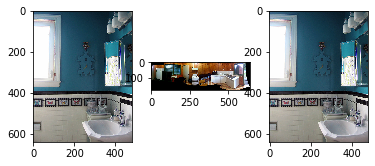

In [15]:
# all_captions 뽑아보기
print('---------------------all_captions----------------------')
print('')
pprint.pprint(all_captions[:3])
# all_img_name_vector 뽑아보기
print('---------------------all_img_name_vector----------------------')
print('')
i = 1
for path in all_img_path[:3]:
    plt.subplot(1,3,i)
    plt.imshow(plt.imread(path))
    i += 1


---------------------train_captions----------------------

['<start> A skateboarder performing a trick on a skateboard ramp. <end>',
 '<start> a person soaring through the air on skis <end>',
 '<start> a wood door with some boards laid against it <end>']
---------------------img_path----------------------

['./train2014/COCO_train2014_000000324909.jpg',
 './train2014/COCO_train2014_000000511972.jpg',
 './train2014/COCO_train2014_000000508809.jpg']


(30000, 414113)

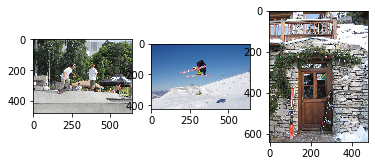

In [16]:

# train_captions 뽑아보기
print('---------------------train_captions----------------------')
print('')
pprint.pprint(train_captions[:3])
# img_name_vector 뽑아보기
print('---------------------img_path----------------------')
print('')
pprint.pprint(img_path[:3])
i = 1
for path in img_path[:3]:
    plt.subplot(1,3,i)
    plt.imshow(plt.imread(path))
    i += 1
len(train_captions), len(all_captions)

## Preprocess the images using InceptionV3
## InceptionV3를 이용한 이미지 전처리
### 다음으로 InceptionV3(미리 학습된 Imagenet)을 이미지를 분류하기 위해서 사용함. 마지막 컨볼루션 레이어의 피쳐를 추출하게 됨
### 처음으로 이미지를 로드해서:
* 이미지를 299 * 299로 리사이징
* 을 사용하여 이미지 형식에 맞는 -1 ~ 1 범위의 픽셀을 포함하도록 이미지를 정상화하십시오. uInceptionV3를 훈련시키기 위해.

Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.




In [8]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

][0]             
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, None, None, 1 147456      average_pooling2d_15[0][0]       
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, None, None, 1 576         conv2d_154[0][0]                 
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, None, None, 1 576         conv2d_157[0][0]                 
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, None, None, 1 576         conv2d_162[0][0]                 
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, None, None, 1 576         conv2d_163[0][0]          

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install -q tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [10]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(img_path))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

1622it [06:04,  4.45it/s]


## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [11]:
# Find the maximum length of any caption in our dataset
# 데이터셋 최고 길이 설정
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
# 5000개의 단어만 선택
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# 토큰 벡터 만들기
train_seqs = tokenizer.texts_to_sequences(train_captions)
# 각각의 최고 길이에 맞게 캡션 패딩. 최고길이 값을 정해주지 않으면 알아서 계산
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# attention weights에 쓰일 최고 길이 계산
max_length = calc_max_length(train_seqs)
# Create training and validation sets using an 80-20 split


## 데이터셋 train,test셋으로 분리

In [19]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_path, cap_vector,test_size=0.2,random_state=0)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## tf.data 데이터셋 만들기
* 모델에 쓸 트레이닝 데이터셋 만들기

In [20]:
# 구성용 파라미터 모델 체우기
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [25]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [28]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [29]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [30]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [31]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9296
Epoch 1 Batch 100 Loss 1.1272
Epoch 1 Batch 200 Loss 0.8927
Epoch 1 Batch 300 Loss 0.8374
Epoch 1 Loss 1.040131
Time taken for 1 epoch 155.23114943504333 sec

Epoch 2 Batch 0 Loss 0.8002
Epoch 2 Batch 100 Loss 0.7492
Epoch 2 Batch 200 Loss 0.7662
Epoch 2 Batch 300 Loss 0.7888
Epoch 2 Loss 0.796142
Time taken for 1 epoch 108.57105803489685 sec

Epoch 3 Batch 0 Loss 0.7342
Epoch 3 Batch 100 Loss 0.7285
Epoch 3 Batch 200 Loss 0.7343
Epoch 3 Batch 300 Loss 0.7039
Epoch 3 Loss 0.725491
Time taken for 1 epoch 108.60666513442993 sec

Epoch 4 Batch 0 Loss 0.7218
Epoch 4 Batch 100 Loss 0.6880
Epoch 4 Batch 200 Loss 0.7521
Epoch 4 Batch 300 Loss 0.6805
Epoch 4 Loss 0.680745
Time taken for 1 epoch 109.48364520072937 sec

Epoch 5 Batch 0 Loss 0.6294
Epoch 5 Batch 100 Loss 0.6337
Epoch 5 Batch 200 Loss 0.6453
Epoch 5 Batch 300 Loss 0.6310
Epoch 5 Loss 0.644755
Time taken for 1 epoch 110.70456576347351 sec

Epoch 6 Batch 0 Loss 0.6536
Epoch 6 Batch 100 Loss 0.6490
Epoch 6

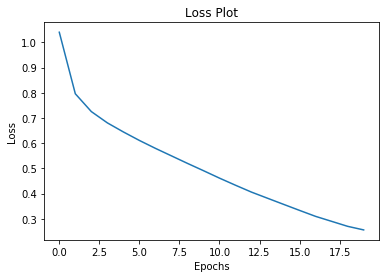

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [34]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [35]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> multiple colorful kites fill the air above a beach <end>
Prediction Caption: a few people on the beach on top of a beach in a cloud covered area <end>


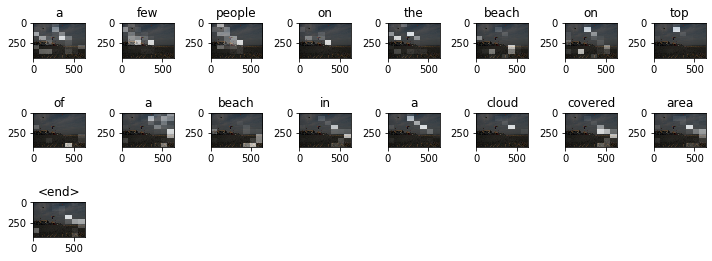

In [36]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


.jpg
a young girl enjoying with glass jeans <end>


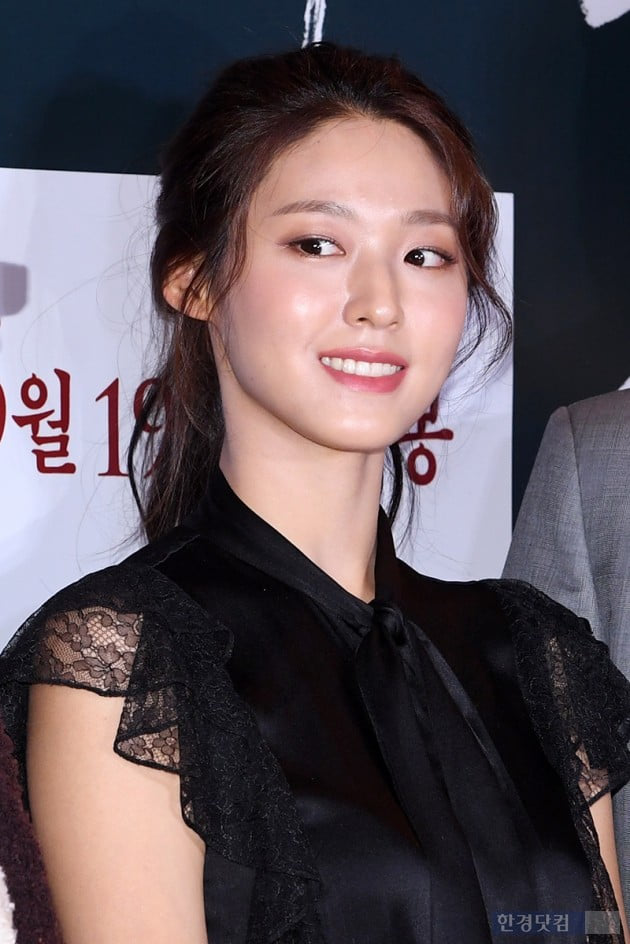

In [48]:
image_url = './practice/02.jpg'
image_extension = image_url[-4:]
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('./image/'+image_extension,
#                                      origin=image_url)

result, attention_plot = evaluate(image_url)
# print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
print(' '.join(result))
Image.open(image_url)
# Image.open(image_path)

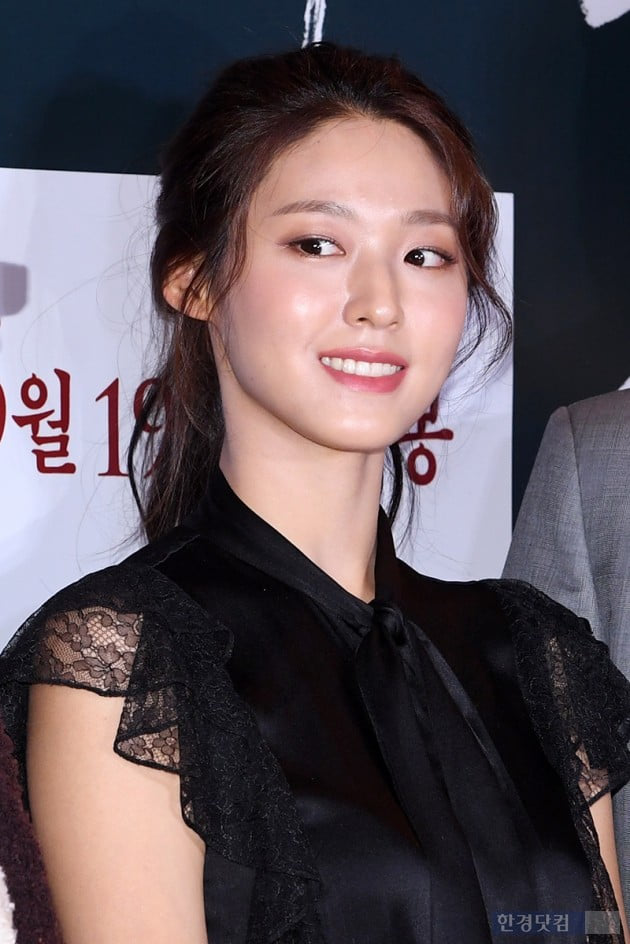

In [43]:
# image_url = 'https://tensorflow.org/images/surf.jpg'
image_url = './practice/01.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)

# result, attention_plot = evaluate(image_path)
# print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_url)
# Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.